In [1]:
import platform, os, sys, datetime, re
from multiprocessing import Pool
from os.path import join
from glob import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
# sys.path.append(join(root_dir,'cvtracer'))
from cvt.TrAQ.Trial import Trial
from cvt.TrAQ.Tank import Tank
from cvt.TrAQ.Group import Group
from cvt.TrAQ.CVTracer import CVTracer, create_named_window, wait_on_named_window
from cvt.utils import *


tracking_dir = '../tracking'

settings_list = [ # trial settings
                  'input_file', 'tracking_dir', 'output_dir', 
                  'new_input_file', 'bkg_file', 'tank_file', 'settings_file', 
                  't_start', 't_end', 'tank_radius', 
                  'bkg_frame_skip', 'bkg_sub_amp',
                  'n_pixel_blur', 'block_size', 'thresh_offset',
                  'min_area', 'max_area', 'RGB', 
                  # tracking settings
                  'ext', 'filename', 'pop', 'age', 'group', 'Nfish', 
                  'date', 'Nframes', 'fps', 'fourcc', 'width', 'height',
                  'video_output_options', 'online_viewer'
                 ]


tank_diameter_vs_age = { 7:0.96, 14:1.04, 21:1.28, 28:1.77, 42:3.38 }


def set_up_tracking(input_file,tracking_dir=tracking_dir):

    ''' Extract trial info from the filename and the video itself. '''

    filename,ext = os.path.splitext(os.path.basename(input_file))
    pop,_,age,group,Nfish,date = filename.split('_')
    Nfish    = int(re.findall('\d+',Nfish)[0])
    date     = ''.join(date.split('-')[:3])
    
    tank_radius = tank_diameter_vs_age[int(age[:-3])]/2

    cap      = cv2.VideoCapture(input_file)
    cap.read()
    Nframes  = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps      = int(cap.get(cv2.CAP_PROP_FPS))
    fourcc   = int(cap.get(cv2.CAP_PROP_FOURCC))
    width    = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height   = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    cap.release()

    ''' Set default tracking parameters. '''

    # By default only track 10 seconds 1 minute in.
    t_start,t_end  = 0,-1 # Times between which to track, in seconds.

    # Background subtraction (for naive background subtraction only).
    bkg_frame_skip = 100   # Using every frame of the video to compute the background takes a while.
                           # Instead we only use one frame in bkg_frame_skip.
    bkg_sub_amp    = 4     # Contrast amplification factor applied after background subtraction.

    # Contour detection.
    n_pixel_blur   =  7    # square-root of n-pixels for threshold blurring
    block_size     = 15    # contour block size
    thresh_offset  = 15    # threshold offset for contour-finding
    min_area       = 25    # minimum area for threhold detection
    max_area       = 60    # maximum area for threhold detection
    RGB            = False # track in color, false does greyscale
    online_viewer  = False # Toggle live preview of tracking.

    # Decide what information to draw on the tracking output video.
    video_output_options = dict(tank=True, repeat_contours=False, all_contours=True, 
                                contour_color=(0,200,255), contour_thickness=1, 
                                points=False, directors=True, timestamp=True)
    
    ''' Define and create necessary folders/files/links. '''
    
    if not os.path.exists(tracking_dir):
        os.mkdir(tracking_dir)

    output_dir = join(tracking_dir,filename)
    if not os.path.exists(output_dir):
        os.mkdir(output_dir)

    new_input_file = input_file
    if not 'windows' in platform.system().lower():
        new_input_file = join(output_dir,'raw'+ext)
        if not os.path.exists(new_input_file):
            os.symlink(os.path.relpath(input_file,output_dir),new_input_file)

    settings_file = join(output_dir,'tracking_settings.txt')
    tank_file = join(output_dir,'tank.pik')
    bkg_file  = join(output_dir,f'background-{bkg_frame_skip}.npy')
    
    
    # The list comprehension version fails to find 'new_input_file'.
    # The explicit loop version works. I have no idea why.
#     settings  = { k:locals()[k] for k in settings_list }
    settings = {}
    for k in settings_list:
        settings[k] = locals()[k]
    
    return settings


''' Prepare a one-step settings saving function to run right before tracking. '''

def save_settings():
    with open(settings_file,'w') as fh:
        for k in settings_list:
            print(f'{k} = {globals()[k]}',file=fh)
    return

# Locate the files

In [7]:
input_files = sorted(glob('../raw_videos/*.avi'))
display(input_files)

['../raw_videos/Pa_Fri_7dpf_GroupA_n2_2020-06-05-120920-0000.avi',
 '../raw_videos/Pa_Fri_7dpf_GroupA_n2b_2020-06-05-103456-0000.avi',
 '../raw_videos/Pa_Fri_7dpf_GroupA_n5_2020-06-05-083453-0000.avi',
 '../raw_videos/Pa_Fri_7dpf_GroupB_n2b_2020-06-05-114635-0000.avi',
 '../raw_videos/Pa_Fri_7dpf_GroupB_n5_2020-06-05-094643-0000.avi']

# Locate the tanks

In [8]:
for input_file in input_files:
    print(input_file)
    settings = set_up_tracking(input_file)
    globals().update(settings)
    tank = Tank(r_cm=tank_radius)
    tank.load_or_locate_and_save(tank_file,input_file)

../raw_videos/Pa_Fri_7dpf_GroupA_n2_2020-06-05-120920-0000.avi

        Tank object loaded from ../tracking/Pa_Fri_7dpf_GroupA_n2_2020-06-05-120920-0000/tank.pik 
../raw_videos/Pa_Fri_7dpf_GroupA_n2b_2020-06-05-103456-0000.avi

        Tank object loaded from ../tracking/Pa_Fri_7dpf_GroupA_n2b_2020-06-05-103456-0000/tank.pik 
../raw_videos/Pa_Fri_7dpf_GroupA_n5_2020-06-05-083453-0000.avi

        Tank object loaded from ../tracking/Pa_Fri_7dpf_GroupA_n5_2020-06-05-083453-0000/tank.pik 
../raw_videos/Pa_Fri_7dpf_GroupB_n2b_2020-06-05-114635-0000.avi

        Tank object loaded from ../tracking/Pa_Fri_7dpf_GroupB_n2b_2020-06-05-114635-0000/tank.pik 
../raw_videos/Pa_Fri_7dpf_GroupB_n5_2020-06-05-094643-0000.avi

        Tank object loaded from ../tracking/Pa_Fri_7dpf_GroupB_n5_2020-06-05-094643-0000/tank.pik 


# Compute backgrounds

Compute the background by averaging frames over the entire video. Save it as `background.npy` in the output directory. Use the pre-existing file if there is one.

In [9]:
def subtract_background(frame,bkg,bkg_sub_amp):
    return 255-np.minimum(255,bkg_sub_amp*np.absolute(frame-bkg)).astype(np.uint8)    


def compute_background(settings):
    
    globals().update(settings)
    
    if os.path.exists(bkg_file):
        bkg  = np.load(bkg_file)
    else:
        t0    = datetime.datetime.now()
        cap   = cv2.VideoCapture(new_input_file)
        _,frame = cap.read()
        bkg   = np.zeros(frame.shape,dtype=float)
        count = 0
        # If bkg_frame_skip is small (<10) it may be faster to use
        # cap.grab instead of cap.set.
        for n in range(0,Nframes,bkg_frame_skip):
            cap.set(cv2.CAP_PROP_POS_FRAMES,n)
            ret,frame = cap.read()
            bkg      += frame
            count    += 1
        bkg   = bkg / count
        np.save(bkg_file,bkg)
        print(datetime.datetime.now()-t0)

    # Show the background.
    print(f'Background obtained by averaging every {bkg_frame_skip}th frame over the entire video:')
    plt.figure(figsize=(9,9))
    plt.imshow(bkg.astype(np.uint))
    plt.show()

../raw_videos/Pa_Fri_7dpf_GroupA_n2_2020-06-05-120920-0000.avi
0:00:42.721272
Background obtained by averaging every 100th frame over the entire video:


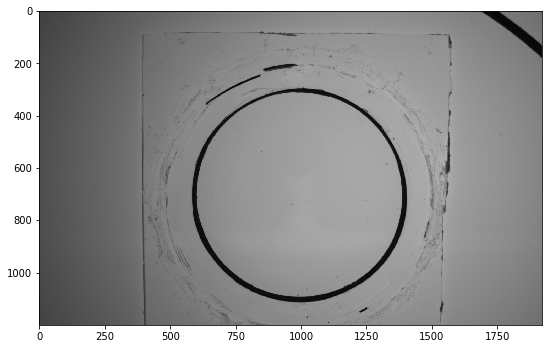

../raw_videos/Pa_Fri_7dpf_GroupA_n2b_2020-06-05-103456-0000.avi
0:00:47.345831
Background obtained by averaging every 100th frame over the entire video:


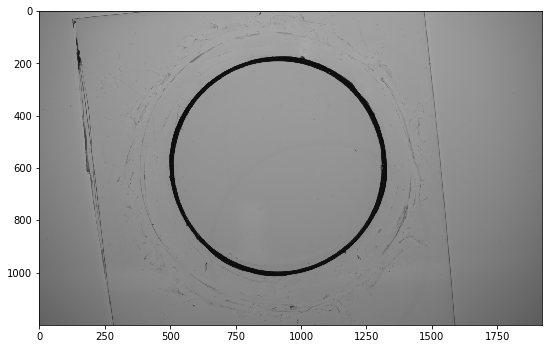

../raw_videos/Pa_Fri_7dpf_GroupA_n5_2020-06-05-083453-0000.avi
0:00:41.880851
Background obtained by averaging every 100th frame over the entire video:


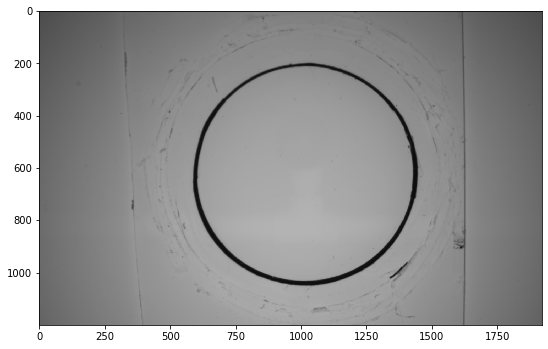

../raw_videos/Pa_Fri_7dpf_GroupB_n2b_2020-06-05-114635-0000.avi
0:00:47.556423
Background obtained by averaging every 100th frame over the entire video:


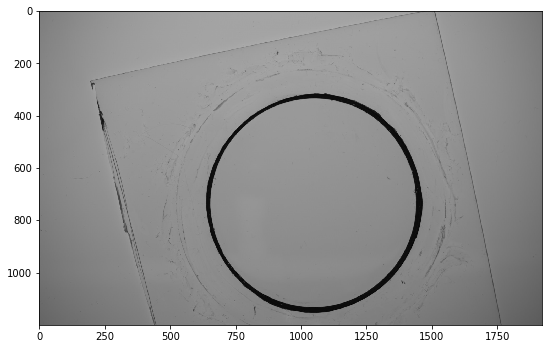

../raw_videos/Pa_Fri_7dpf_GroupB_n5_2020-06-05-094643-0000.avi
0:00:42.756247
Background obtained by averaging every 100th frame over the entire video:


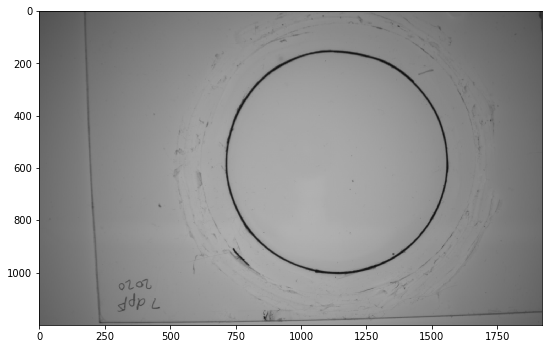

In [10]:
for input_file in input_files:
    print(input_file)
    settings = set_up_tracking(input_file)
    compute_background(settings)

### Track with simple background subtraction

In [11]:
def track(settings):
    
    globals().update(settings)
    save_settings()
    
    trial = Trial()
    trial.init(video_file=new_input_file, output_dir=output_dir, n=Nfish, t=pop, date=date, 
               fps=fps, tank_radius=tank_radius, t_start=t_start, t_end=t_end)

    cvt = CVTracer(trial, n_pixel_blur=n_pixel_blur, block_size=block_size, 
                   threshold_offset=thresh_offset, min_area=min_area, RGB=True,
                   online=online_viewer)
    
    bkg = np.load(bkg_file)
    
    try:
        cvt.set_frame(cvt.frame_start)
        for i_frame in range(cvt.frame_start, cvt.frame_end+1):
            if cvt.get_frame():
                cvt.frame = subtract_background(cvt.frame,bkg,bkg_sub_amp)
                cvt.mask_tank()
                cvt.detect_contours()
                cvt.analyze_contours()
                cvt.connect_frames()
                cvt.update_trial()
                cvt.draw(**video_output_options)
                cvt.write_frame()
                if not cvt.post_frame(delay=1):
                    break
                cvt.print_current_frame()
        cvt.release()
        cvt.trial.save()
    except:
        %tb
        cvt.release()

In [12]:
display(input_files)

['../raw_videos/Pa_Fri_7dpf_GroupA_n2_2020-06-05-120920-0000.avi',
 '../raw_videos/Pa_Fri_7dpf_GroupA_n2b_2020-06-05-103456-0000.avi',
 '../raw_videos/Pa_Fri_7dpf_GroupA_n5_2020-06-05-083453-0000.avi',
 '../raw_videos/Pa_Fri_7dpf_GroupB_n2b_2020-06-05-114635-0000.avi',
 '../raw_videos/Pa_Fri_7dpf_GroupB_n5_2020-06-05-094643-0000.avi']

In [13]:
for input_file in input_files:
    print(input_file)
    settings = set_up_tracking(input_file)
    track(settings)

../raw_videos/Pa_Fri_7dpf_GroupA_n2_2020-06-05-120920-0000.avi

        Generating new Trial object.

        Tank object loaded from ../tracking/Pa_Fri_7dpf_GroupA_n2_2020-06-05-120920-0000/tank.pik 
2 individuals in trial
15
Using Gaussian Adaptive Threshold
Using Inverted Binary Threshold with [0, 100].
 Group of 2
       Current tracking time: 00:19:11:36 
       Video capture released.

        Trial object saved as ../tracking/Pa_Fri_7dpf_GroupA_n2_2020-06-05-120920-0000/trial.pik 
../raw_videos/Pa_Fri_7dpf_GroupA_n2b_2020-06-05-103456-0000.avi

        Generating new Trial object.

        Tank object loaded from ../tracking/Pa_Fri_7dpf_GroupA_n2b_2020-06-05-103456-0000/tank.pik 
2 individuals in trial
15
Using Gaussian Adaptive Threshold
Using Inverted Binary Threshold with [0, 100].
 Group of 2
       Current tracking time: 00:21:11:43 
       Video capture released.

        Trial object saved as ../tracking/Pa_Fri_7dpf_GroupA_n2b_2020-06-05-103456-0000/trial.pik 
../raw_vide

In [ ]:
# def worker(input_file):
#     print(input_file)
#     settings = set_up_tracking(input_file)
#     track(settings)
#     return

# pool = Pool(5)
# pool.map(worker,input_files[:1])

In [ ]:
# cv2.destroyAllWindows()